In [71]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, GridSearchCV

from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score, make_scorer

from sklearn.inspection import PartialDependenceDisplay
from sklearn import tree

from imblearn.under_sampling import RandomUnderSampler

In [47]:
df = pd.read_csv("Dataset.csv")

In [48]:
AGE_COLUMN = "Idade"
INCOME_COLUMN = "Renda Anual (em $)"
GENDER_COLUMN = "Gênero"
NAVIGATION_TIME_COLUMN = "Tempo no Site (min)"
AD_COLUMN = "Anúncio Clicado"
BUY_COLUMN = "Compra (0 ou 1)"

# Feature Engenierieng
INCOME_AGE_RELATION_COLUMN = "Renda Por Idade"
INCOME_NAVIGATION_TIME_RELATION_COLUMN = "Renda Por Tempo no Site"
NAVIGATION_TIME_AGE_RELATION_COLUMN = "Tempo no Site Por Idade"

In [49]:
df.describe()

,Idade,Renda Anual (em $),Tempo no Site (min),Compra (0 ou 1)
count,190.000000,189.000000,200.000000,200.000000
mean,38.510526,58253.968254,17.349090,0.330000
std,12.679918,25612.061811,7.724088,0.471393
min,18.000000,30000.000000,-1.000000,0.000000
25%,28.000000,30000.000000,10.860240,0.000000
50%,38.000000,50000.000000,18.197552,0.000000
75%,50.000000,70000.000000,23.887341,1.000000
max,59.000000,100000.000000,29.853484,1.000000


In [50]:
df = df[df[NAVIGATION_TIME_COLUMN] > 0]

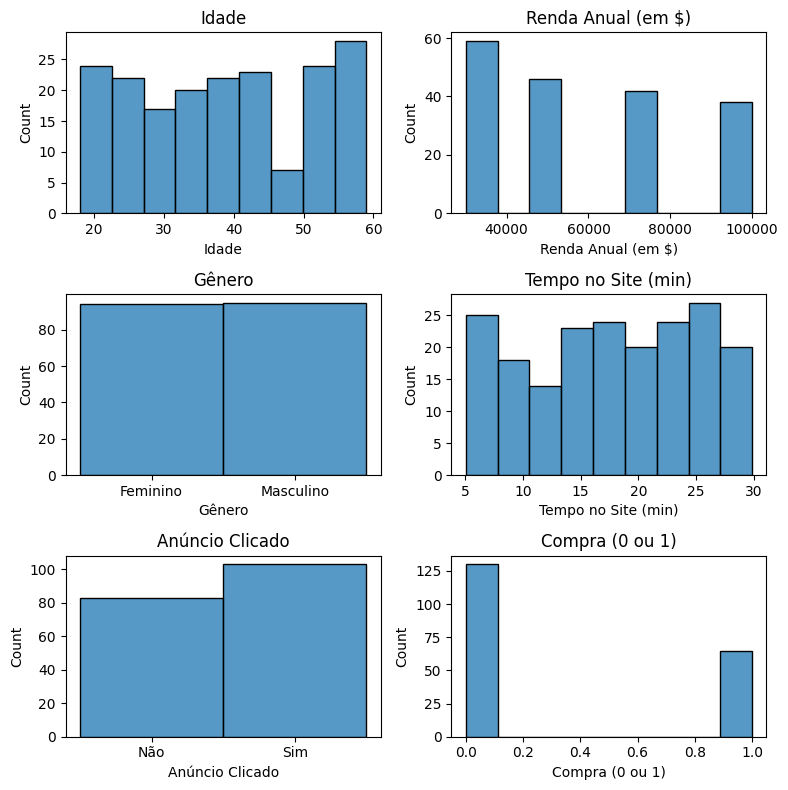

In [51]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 8))

axs = list()
for ax in axes:
    axs.extend(ax)

for ax, column in zip(axs, df.columns):
    sns.histplot(data=df, x=column, ax=ax)
    ax.set_title(column)

plt.tight_layout()
plt.show()

In [52]:
df[AGE_COLUMN] = df[AGE_COLUMN] / df[AGE_COLUMN].max()
df[INCOME_COLUMN] = df[INCOME_COLUMN] / df[INCOME_COLUMN].max()
df[GENDER_COLUMN] = (df[GENDER_COLUMN] == "Masculino").astype(int)
df[NAVIGATION_TIME_COLUMN] = df[NAVIGATION_TIME_COLUMN] / df[NAVIGATION_TIME_COLUMN].max()
df[AD_COLUMN] = (df[AD_COLUMN] == "Sim").astype(int)

df[INCOME_AGE_RELATION_COLUMN] = df[INCOME_COLUMN] / df[AGE_COLUMN]
df[INCOME_NAVIGATION_TIME_RELATION_COLUMN] = df[INCOME_COLUMN] / df[NAVIGATION_TIME_COLUMN]
df[NAVIGATION_TIME_AGE_RELATION_COLUMN] = df[NAVIGATION_TIME_COLUMN] / df[AGE_COLUMN]

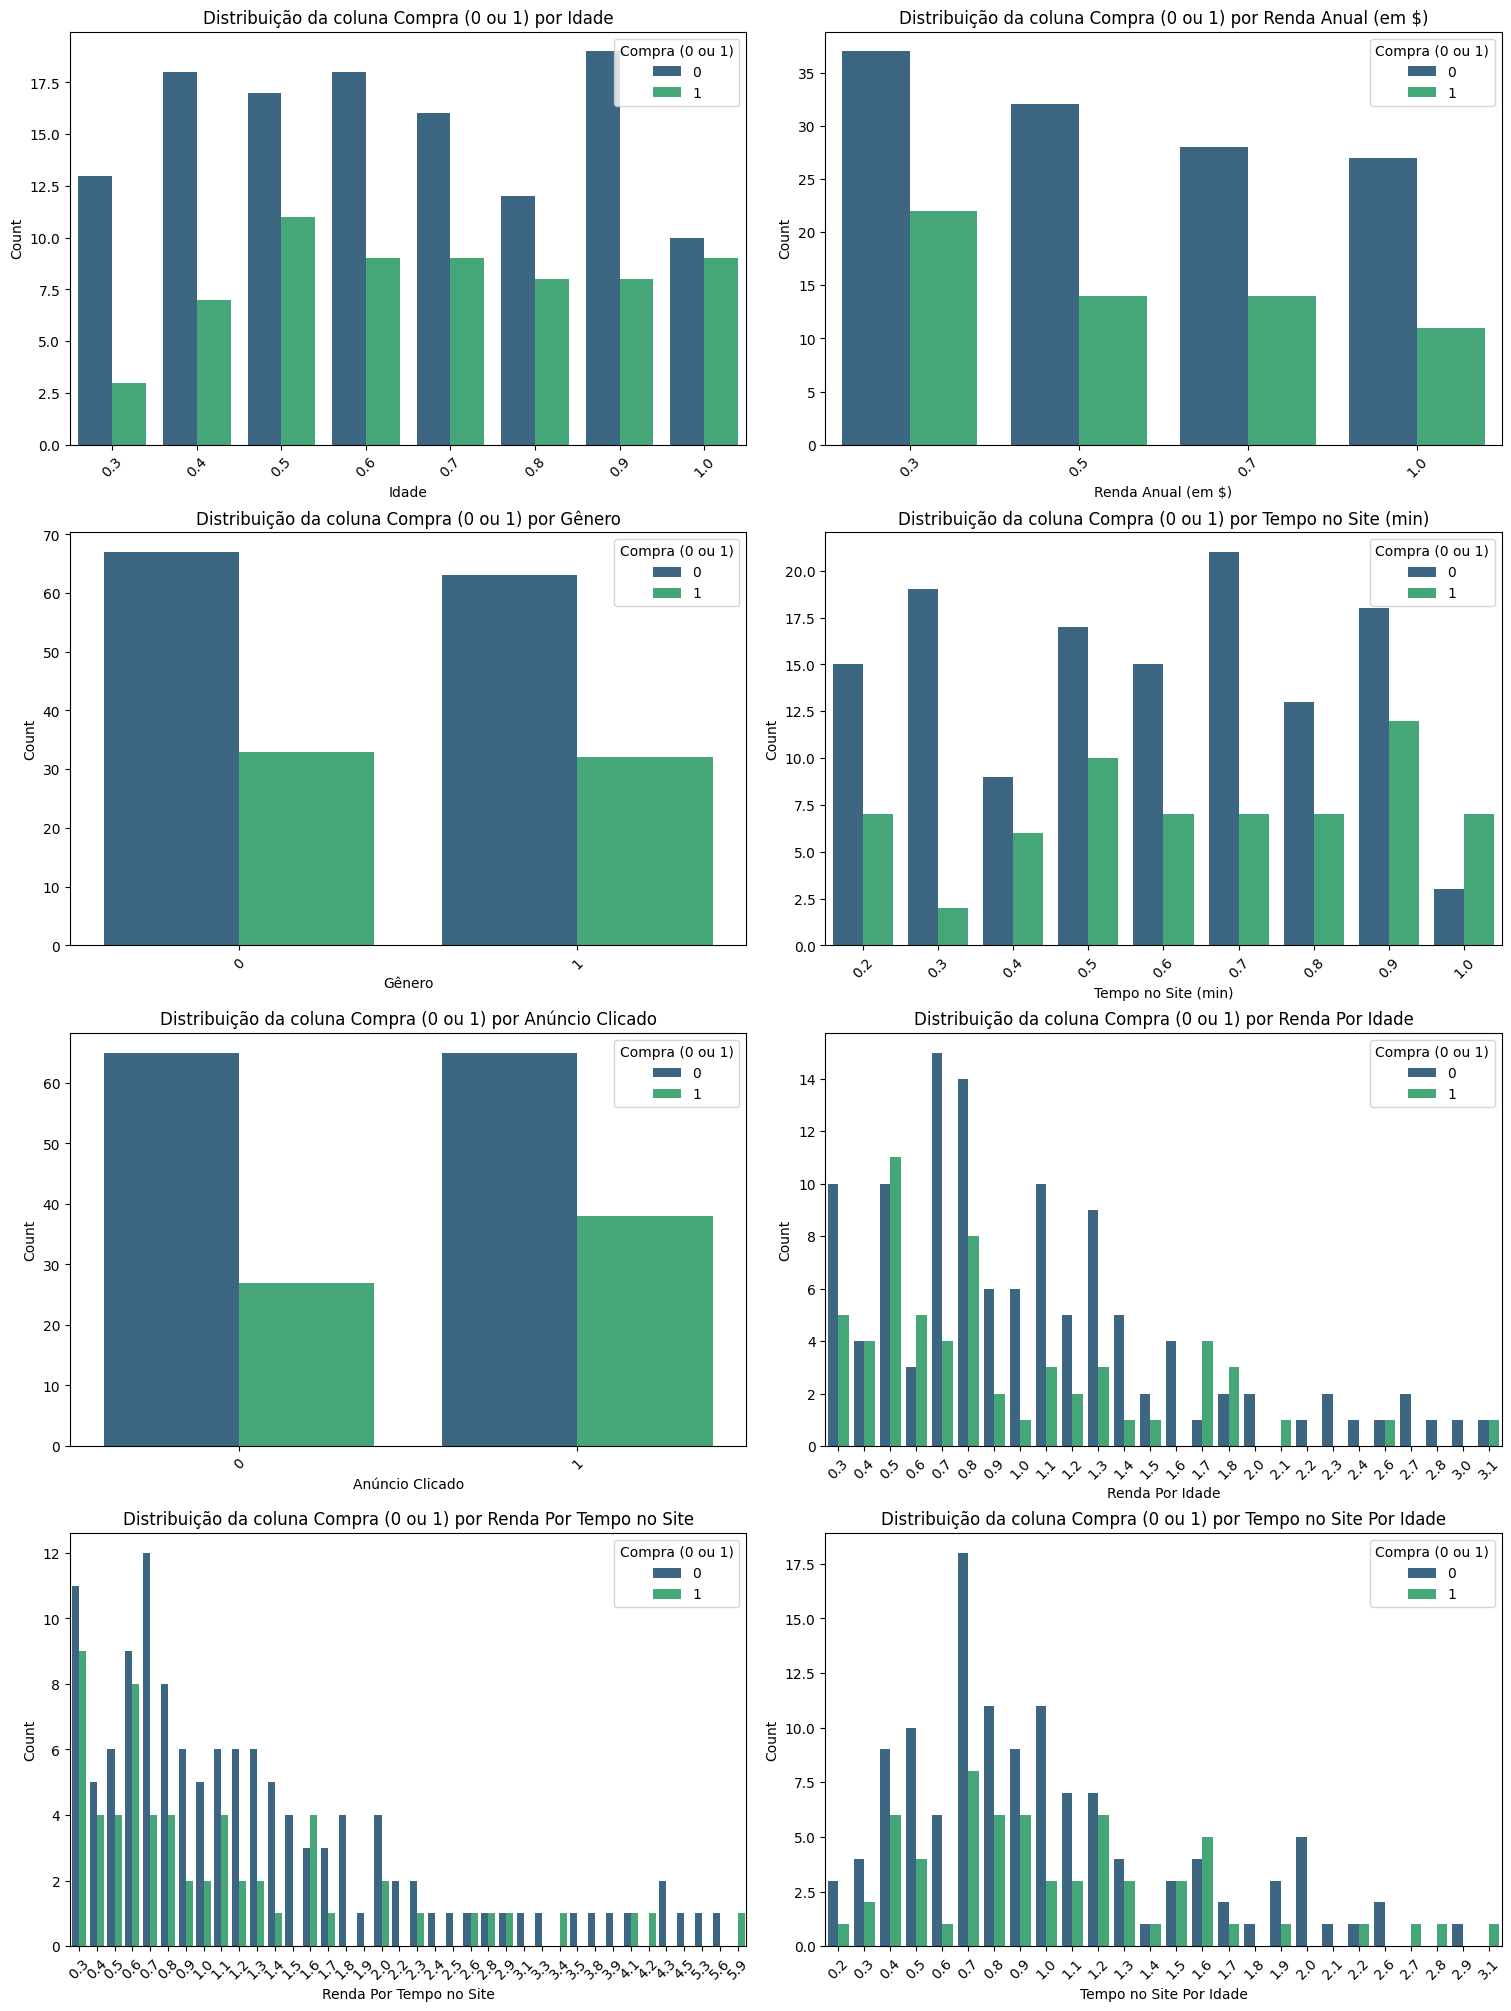

In [53]:
dfr = df.copy()
dfr[AGE_COLUMN] = dfr[AGE_COLUMN].round(1)
dfr[INCOME_AGE_RELATION_COLUMN] = dfr[INCOME_AGE_RELATION_COLUMN].round(1)
dfr[INCOME_NAVIGATION_TIME_RELATION_COLUMN] = dfr[INCOME_NAVIGATION_TIME_RELATION_COLUMN].round(1)
dfr[NAVIGATION_TIME_AGE_RELATION_COLUMN] = dfr[NAVIGATION_TIME_AGE_RELATION_COLUMN].round(1)
dfr[NAVIGATION_TIME_COLUMN] = dfr[NAVIGATION_TIME_COLUMN].round(1)

columns_to_plot = [col for col in dfr.columns if col != BUY_COLUMN]
num_columns = len(columns_to_plot)

cols = 2
rows = np.ceil(num_columns / cols)
fig, axes = plt.subplots(int(rows), int(cols), figsize=(15, 5 * rows), constrained_layout=True)

axes = axes.flatten()

for idx, column in enumerate(columns_to_plot):
    ax = axes[idx]

    grouped = dfr.groupby([column, BUY_COLUMN]).size().reset_index(name='counts')

    sns.barplot(data=grouped, x=column, y='counts', hue=BUY_COLUMN, ax=ax, palette='viridis')
    ax.set_title(f'Distribuição da coluna {BUY_COLUMN} por {column}')
    ax.set_ylabel('Count')
    ax.set_xlabel(column)
    ax.legend(title=BUY_COLUMN)
    ax.tick_params(axis='x', rotation=45)

for idx in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[idx])

plt.show()


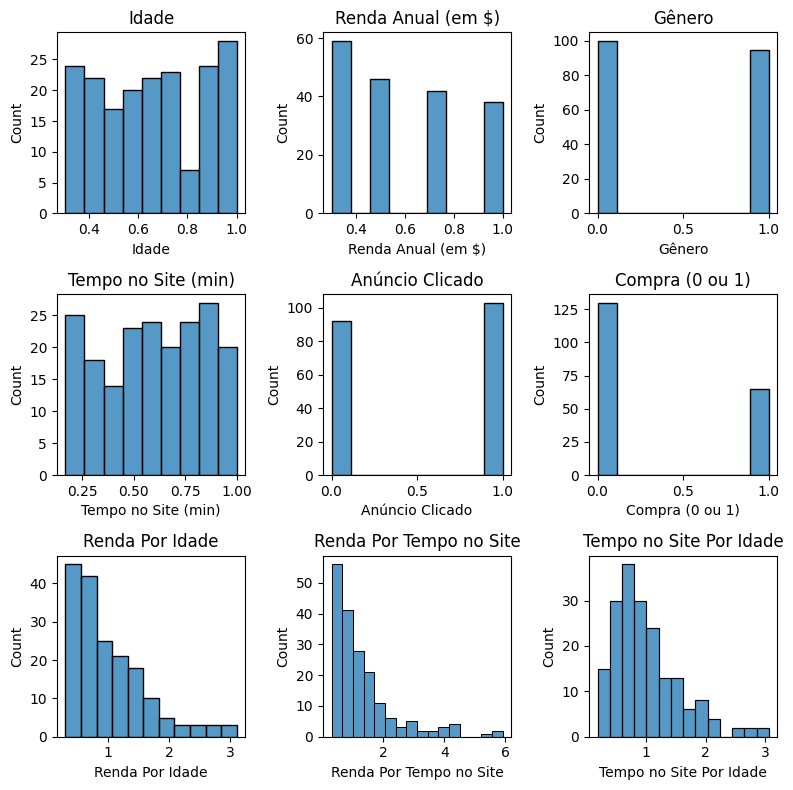

In [54]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))

axs = list()
for ax in axes:
    axs.extend(ax)

for ax, column in zip(axs, df.columns):
    sns.histplot(data=df, x=column, ax=ax)
    ax.set_title(column)

plt.tight_layout()
plt.show()

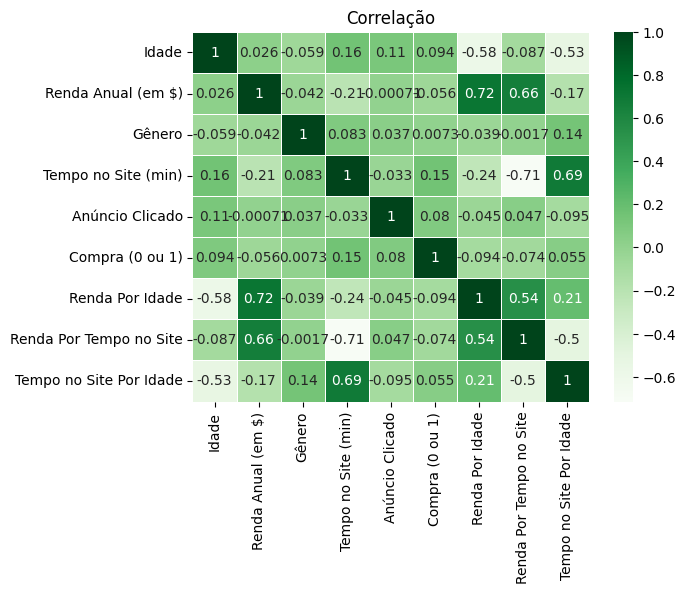

In [55]:
plt.title("Correlação")
_ = sns.heatmap(df.corr(method="pearson"), annot=True, linewidths=0.5, cmap="Greens")

In [56]:
class AgeAndGenderBasedImputer(BaseEstimator, TransformerMixin):
    def fit(self, X: pd.DataFrame, y=None):
        self.group_means_ = X.groupby([ AGE_COLUMN, GENDER_COLUMN]).mean(numeric_only=True)
        return self

    def transform(self, X: pd.DataFrame):
        def fill_value(row):
            if pd.isna(row[INCOME_COLUMN]):
                if pd.isna(row[AGE_COLUMN]):
                    raise Exception("Age cannot be NaN.")

                if pd.isna(row[GENDER_COLUMN]):
                    raise Exception("Gender cannot be NaN.")

                group_mean = self.group_means_.loc[(row[AGE_COLUMN], row[GENDER_COLUMN])]
                return group_mean[INCOME_COLUMN] if not group_mean.empty else np.nan
            return row[INCOME_COLUMN]
        
        X[INCOME_COLUMN] = X.apply(fill_value, axis=1)
        return X

In [57]:
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns: list[str] = [ ]):
        super().__init__()
        self.columns = columns

    def fit(self, X: pd.DataFrame, y=None):
        return self  

    def transform(self, X: pd.DataFrame):
        X = X.drop(columns=self.columns)
        return X

In [58]:
class NaNRowDropper(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()

    def fit(self, X: pd.DataFrame, y=None):
        return self

    def transform(self, X: pd.DataFrame):
        return X.dropna()

In [59]:
transform_pipeline = Pipeline(steps=[
    ('drop_rows_with_nan', NaNRowDropper()),
    ('drop_columns', ColumnDropper(columns=[
        GENDER_COLUMN,
        INCOME_COLUMN,
        AD_COLUMN,
    ]))
])

data = transform_pipeline.fit_transform(df)

In [60]:
X = data.drop(columns=BUY_COLUMN)
y = data[BUY_COLUMN]

In [61]:
def execute_search(estimator, param_grid, execute_undersampling: bool = False) -> tuple[float, BaseEstimator]:
    grid_search = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        scoring=make_scorer(f1_score, average="macro"),
        cv=5,
        verbose=1,
        n_jobs=-1
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    undersampler = RandomUnderSampler(random_state=42)

    scores = list()
    models = list()

    for train_idx, val_idx in cv.split(X, y):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

        if (execute_undersampling):
            X_train, y_train = undersampler.fit_resample(X_train, y_train)

        model = grid_search.fit(X_train, y_train).best_estimator_

        score = f1_score(y_val, model.predict(X_val), average="macro")
        
        scores.append(score)
        models.append(model)
    
    best_idx = np.argmax(scores)

    return scores[best_idx], models[best_idx]

In [62]:
classifiers_class_balancing: list[ClassifierMixin] = [
    (
        LogisticRegression(),
        { 'class_weight': [ 'balanced' ], 'random_state': [ 42 ], }
    ),
    (
        SVC(),
        {
            'C': [ 0.1, 1, 10, 100 ],
            'kernel': [ 'linear', 'rbf', 'poly', 'sigmoid' ],
            'gamma': [ 'scale', 'auto', 0.01, 0.1, 1 ],
            'class_weight': [ 'balanced' ],
            'random_state': [ 42 ],
        }
    ),
    (
        DecisionTreeClassifier(),
        {
            'criterion': [ 'gini', 'entropy' ],
            'max_depth': [ None, 5, 10, 20 ],
            'min_samples_split': [ 2, 5, 10 ],
            'min_samples_leaf': [ 1, 2, 5 ],
            'class_weight': [ 'balanced' ],
            'random_state': [ 42 ],
        }
    ),
    (
        RandomForestClassifier(),
        {
            'n_estimators': [ 50, 100, 200 ],
            'max_depth': [ None, 10, 20 ],
            'min_samples_split': [ 2, 5, 10 ],
            'min_samples_leaf': [ 1, 2, 5 ],
            'bootstrap': [ True, False ],
            'class_weight': [ 'balanced' ],
            'random_state': [ 42 ],
        }
    ),
]

In [63]:
results_with_class_balancing = [ execute_search(classifier, params, execute_undersampling=False) for classifier, params in classifiers_class_balancing ]

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Fitting 5 folds for ea

In [64]:
classifiers_undersampling: list[ClassifierMixin] = [
    (
        LogisticRegression(),
        { 'random_state': [ 42 ], }
    ),
    (
        SVC(),
        {
            'C': [ 0.1, 1, 10, 100 ],
            'kernel': [ 'linear', 'rbf', 'poly', 'sigmoid' ],
            'gamma': [ 'scale', 'auto', 0.01, 0.1, 1 ],
            'random_state': [ 42 ],
        }
    ),
    (
        DecisionTreeClassifier(),
        {
            'criterion': [ 'gini', 'entropy' ],
            'max_depth': [ None, 5, 10, 20 ],
            'min_samples_split': [ 2, 5, 10 ],
            'min_samples_leaf': [ 1, 2, 5 ],
            'random_state': [ 42 ],
        }
    ),
    (
        RandomForestClassifier(),
        {
            'n_estimators': [ 50, 100, 200 ],
            'max_depth': [ None, 10, 20 ],
            'min_samples_split': [ 2, 5, 10 ],
            'min_samples_leaf': [ 1, 2, 5 ],
            'bootstrap': [ True, False ],
            'random_state': [ 42 ],
        }
    ),
]

In [65]:
results_with_undersampling = [ execute_search(classifier, params, execute_undersampling=True) for classifier, params in classifiers_undersampling ]

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Fitting 5 folds for ea

In [66]:
print(*results_with_undersampling, sep='\n')

(0.56575682382134, LogisticRegression(random_state=42))
(0.520851818988465, SVC(C=10, gamma=1, kernel='sigmoid', random_state=42))
(0.668560606060606, DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42))
(0.6328671328671329, RandomForestClassifier(min_samples_leaf=2, random_state=42))


In [67]:
print(*results_with_class_balancing, sep='\n')

(0.55, LogisticRegression(class_weight='balanced', random_state=42))
(0.5333333333333333, SVC(C=1, class_weight='balanced', gamma='auto', kernel='sigmoid',
    random_state=42))
(0.5541795665634675, DecisionTreeClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=5,
                       random_state=42))
(0.625, RandomForestClassifier(class_weight='balanced', min_samples_leaf=5,
                       n_estimators=200, random_state=42))


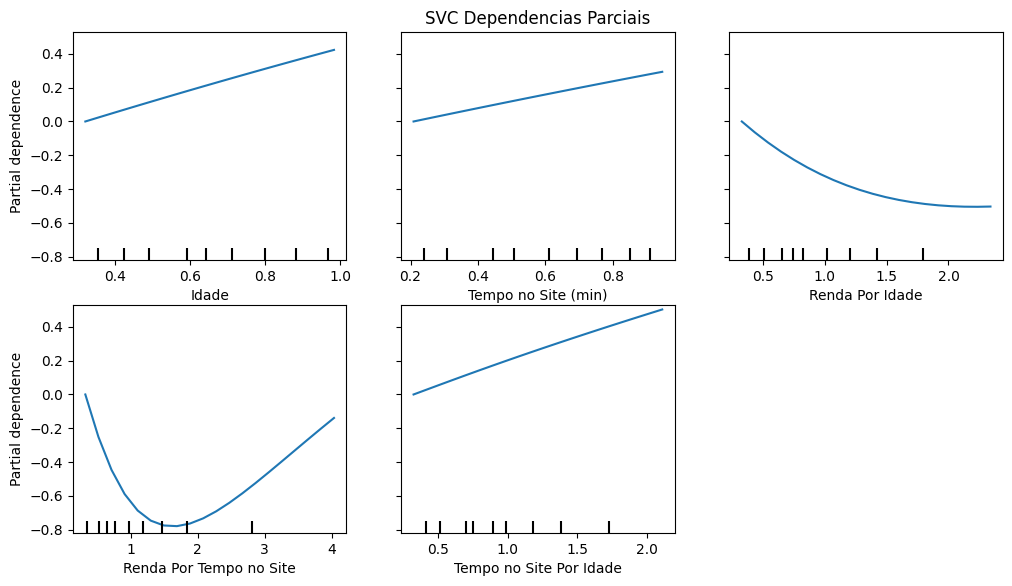

In [68]:
fig, ax = plt.subplots(figsize=(12, 6.5))

plt.title("SVC Dependencias Parciais")

PartialDependenceDisplay.from_estimator(results_with_class_balancing[1][1], X, X.columns, grid_resolution=20, ax=ax, centered=True)

plt.show()

In [69]:
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': results_with_undersampling[2][1].feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances)

                   Feature  Importance
1      Tempo no Site (min)    0.520399
2          Renda Por Idade    0.222333
4  Tempo no Site Por Idade    0.155372
3  Renda Por Tempo no Site    0.101897
0                    Idade    0.000000


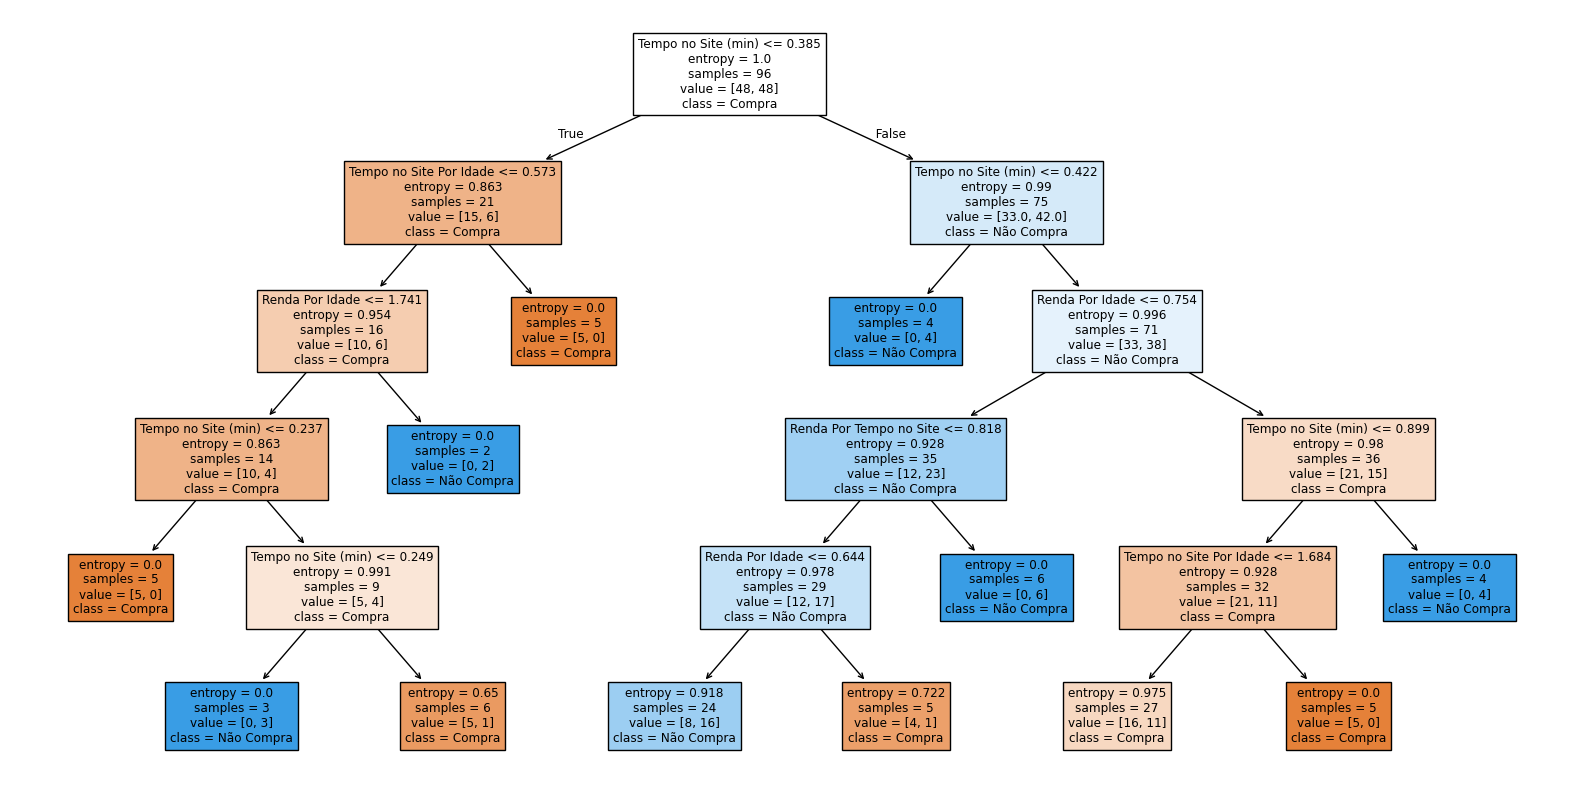

In [70]:
plt.figure(figsize=(20, 10))
tree.plot_tree(results_with_undersampling[2][1], feature_names=X.columns, class_names=[ "Compra", "Não Compra" ], filled=True)
plt.show()